# Kaggle House competition
trying predict house price

In [1]:
# all imports I need
import pandas as pd
import numpy as np
#for cross_feature
from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error

#models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

#for pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer

#feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from scipy import stats

import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

# Load data
it is possible to load data from [here](https://www.kaggle.com/c/home-data-for-ml-course/data "Kaggle's House competition")

In [2]:
TRAIN_PATH = "train.csv"
TEST_PATH = 'test.csv'
Full_train = pd.read_csv(TRAIN_PATH,index_col='Id')
Full_test = pd.read_csv(TEST_PATH)
Full_train.dropna(axis=0,subset=['SalePrice'], inplace=True)
y_full = Full_train.SalePrice
X_full = Full_train.drop(axis=1, columns=['SalePrice'])

In [3]:
Full_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [4]:
columns_to_drop = ['MoSold','YrSold'] # these columns could be cause of data leakage, it is better to drop them
X_full.drop(columns_to_drop, axis=1, inplace=True)

In [5]:
numeric_col = list((X_full.select_dtypes(exclude='object')).columns)
string_col = list((X_full.select_dtypes(include='object')).columns)
low_categorical_col = [col for col in X_full.columns
                  if X_full[col].dtype == 'object' and X_full[col].nunique() <10]

In [6]:
X_full.shape

(1460, 77)

# Look inside data

## explore data

#### first, lets see dtypes of dateframes

In [7]:
# to see dtypes of all columns, we need change max_rows
pd.set_option('display.max_rows', 80)
Full_train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


OverallQual, OverallCond, MSSubClass - These features probably should be categorical, not numerical

In [8]:
should_be_categorical = ['OverallQual', 'OverallCond', 'MSSubClass']

### find all nans
Probably, the only missed value is 'Electricial'(or maybe there was no electricity in this house?), others should be stay as missed values

In [9]:
Full_train.isna().sum()[Full_train.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [121]:
Full_train[numeric_col].isna().sum()[Full_train[numeric_col].isna().sum() > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

## numeric data

In [124]:
full_x_corr = Full_train.corr()
full_x_corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


For all featurees contain "YrBlt" regplot should be higher order then 1

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

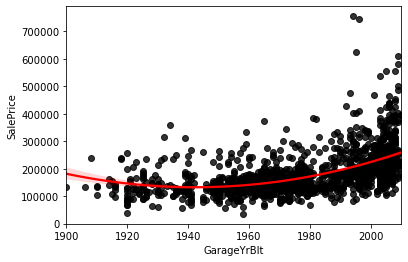

In [12]:
sns.regplot(x='GarageYrBlt', y='SalePrice',data=Full_train,order=2,
           scatter_kws={"color": "black"}, line_kws={"color": "red"})

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

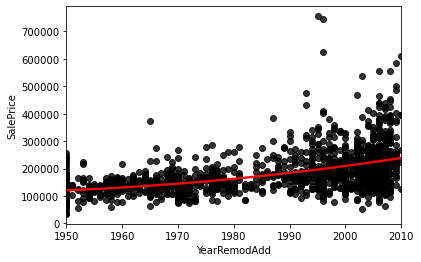

In [132]:
sns.regplot(x='YearRemodAdd', y='SalePrice',data=Full_train,order=2,
           scatter_kws={"color": "black"}, line_kws={"color": "red"})

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

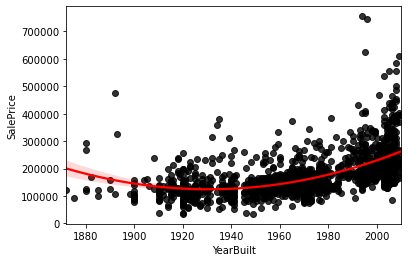

In [125]:
sns.regplot(x='YearBuilt', y='SalePrice',data=Full_train,order=2,
           scatter_kws={"color": "black"}, line_kws={"color": "red"})

2ndFlrSF is probably 2nd order, need to keep in mind

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

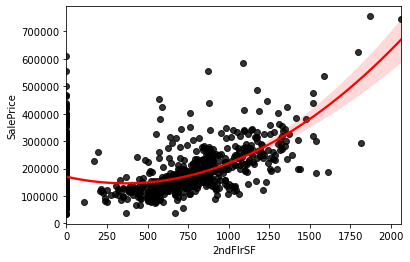

In [133]:
sns.regplot(x='2ndFlrSF', y='SalePrice',data=Full_train,order=2,
           scatter_kws={"color": "black"}, line_kws={"color": "red"})

In [14]:
Full_train['2ndFlrSF'].corr(y_full)

0.31933380283206764

Find significant correlation for price (that have absolute value > 0.5)

In [15]:
price_corr = full_x_corr[abs(full_x_corr) > 0.5]['SalePrice'].dropna()
price_corr

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

Easy way is drop nan, while calculating correlation and p-value

In [16]:
Full_train[numeric_col].isna().sum()[Full_train[numeric_col].isna().sum() > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [17]:
contains_nan = ['LotFrontage','GarageYrBlt','MasVnrArea']

In [18]:
df = Full_train[numeric_col].drop(columns=contains_nan)
features_to_observe = list(df.columns)

### Finding best features
checking correlation and p-value for numeric features

In [19]:
for feature in features_to_observe:
    pearson_coef, p_value = stats.pearsonr(Full_train[feature],y_full)
    #if (abs(pearson_coef) > 0.5):
    print('Feature:',feature)
    print('The correlation coefficient is:', pearson_coef, 'the p-value is:', p_value)

Feature: MSSubClass
The correlation coefficient is: -0.0842841351265952 the p-value is: 0.0012664716847503312
Feature: LotArea
The correlation coefficient is: 0.2638433538714057 the p-value is: 1.1231391549193063e-24
Feature: OverallQual
The correlation coefficient is: 0.7909816005838048 the p-value is: 2.185675268e-313
Feature: OverallCond
The correlation coefficient is: -0.07785589404867801 the p-value is: 0.0029123512679174826
Feature: YearBuilt
The correlation coefficient is: 0.5228973328794968 the p-value is: 2.9902290990158995e-103
Feature: YearRemodAdd
The correlation coefficient is: 0.5071009671113862 the p-value is: 3.1649482419200737e-96
Feature: BsmtFinSF1
The correlation coefficient is: 0.3864198062421533 the p-value is: 3.3941098292907553e-53
Feature: BsmtFinSF2
The correlation coefficient is: -0.011378121450215144 the p-value is: 0.663998650834577
Feature: BsmtUnfSF
The correlation coefficient is: 0.2144791055469689 the p-value is: 1.1829757963600795e-16
Feature: TotalBsm

We can see, that the only meaningfull values are same that in price_corr. But there is some features that wee can add to see how it will influence on SalesPrice.(Having fireplace, Pool, 2nd floor etc.)

#### Creating new features
We can try to create new features and see, how it will work out

In [20]:
porch = ['EnclosedPorch', 'OpenPorchSF','3SsnPorch','ScreenPorch']
BSM_bath = ['BsmtFullBath', 'BsmtHalfBath']
bath = ['FullBath', 'HalfBath']

In [100]:
area = 'area'

In [101]:
for col in Full_train.columns:
    if 'area' in str.lower(col):
        print(col)

LotArea
MasVnrArea
GrLivArea
GarageArea
PoolArea


In [112]:
areas = ['LotArea', 'MasVnrArea', 'GrLivArea','GarageArea','PoolArea']

In [113]:
selected_features_df = Full_train[price_corr.index]
selected_features_df['Has_pool'] = Full_train['PoolArea'] > 0
selected_features_df['Has_fireplace'] = Full_train['Fireplaces'] > 0
selected_features_df['Total_porch'] = Full_train[porch].sum(axis=1)
selected_features_df['Total_BSM_bath'] = Full_train[BSM_bath].sum(axis=1)
selected_features_df['Has_2flr'] = Full_train['2ndFlrSF'] > 0
selected_features_df['Total_Bath'] = Full_train[bath].sum(axis=1)
selected_features_df['Has_garage'] = Full_train['GarageArea'] > 0
selected_features_df['Total_area'] = Full_train[areas].sum(axis=1)
selected_features_df

<ipython-input-113-b8063d388702>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_df['Has_pool'] = Full_train['PoolArea'] > 0
<ipython-input-113-b8063d388702>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_df['Has_fireplace'] = Full_train['Fireplaces'] > 0
<ipython-input-113-b8063d388702>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,Has_pool,Has_fireplace,Total_porch,Total_BSM_bath,Has_2flr,Total_Bath,Has_garage,Total_area
Id,,,,,,,,,,,,,,,,,,,
1,7,2003,2003,856,856,1710,2,8,2,548,208500,False,False,61,1,True,3,True,10904.0
2,6,1976,1976,1262,1262,1262,2,6,2,460,181500,False,True,0,1,False,2,True,11322.0
3,7,2001,2002,920,920,1786,2,6,2,608,223500,False,True,42,1,True,3,True,13806.0
4,7,1915,1970,756,961,1717,1,7,3,642,140000,False,True,307,1,True,1,True,11909.0
5,8,2000,2000,1145,1145,2198,2,9,3,836,250000,False,True,84,1,True,3,True,17644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,6,1999,2000,953,953,1647,2,7,2,460,175000,False,True,40,0,True,3,True,10024.0
1457,6,1978,1988,1542,2073,2073,2,7,2,500,210000,False,True,0,1,False,2,True,15867.0
1458,7,1941,2006,1152,1188,2340,2,9,1,252,266500,False,True,60,0,True,2,True,11634.0


Now lets repeat process with correaltion and p_value

In [114]:
for feature in selected_features_df.columns:
    pearson_coef, p_value = stats.pearsonr(selected_features_df[feature],y_full)
    #if (abs(pearson_coef) > 0.5):
    print('Feature:',feature)
    print('The correlation coefficient is:', pearson_coef, 'the p-value is:', p_value)

Feature: OverallQual
The correlation coefficient is: 0.7909816005838048 the p-value is: 2.185675268e-313
Feature: YearBuilt
The correlation coefficient is: 0.5228973328794968 the p-value is: 2.9902290990158995e-103
Feature: YearRemodAdd
The correlation coefficient is: 0.5071009671113862 the p-value is: 3.1649482419200737e-96
Feature: TotalBsmtSF
The correlation coefficient is: 0.6135805515591954 the p-value is: 9.484229391507914e-152
Feature: 1stFlrSF
The correlation coefficient is: 0.6058521846919146 the p-value is: 5.394710618971284e-147
Feature: GrLivArea
The correlation coefficient is: 0.708624477612652 the p-value is: 4.518033646780971e-223
Feature: FullBath
The correlation coefficient is: 0.560663762748446 the p-value is: 1.2364700667605807e-121
Feature: TotRmsAbvGrd
The correlation coefficient is: 0.5337231555820281 the p-value is: 2.772280932958432e-108
Feature: GarageCars
The correlation coefficient is: 0.640409197258352 the p-value is: 2.498644167178942e-169
Feature: GarageAr

Total_Bath is new feature that worth attention
(probably it is not linear)

<AxesSubplot:xlabel='Total_Bath', ylabel='SalePrice'>

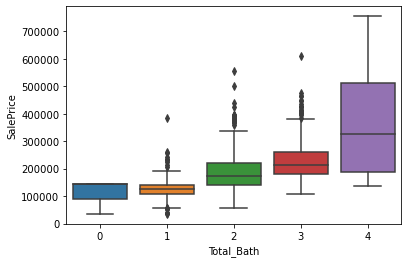

In [116]:
sns.boxplot(x='Total_Bath', y='SalePrice', data=selected_features_df)

In [24]:
selected_features = list(price_corr.index)
selected_features += ['Total_Bath']
selected_features

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice',
 'Total_Bath']

## low_cardinality features

In [136]:
low_cardinality_df = Full_train[low_categorical_col]
low_cardinality_df

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


In [139]:
low_cardinality_df.isna().sum()[low_cardinality_df.isna().sum() > 0]

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

I will return to handling nans later, for now I will drop it

In [146]:
low_cardinality_cols_with_nans = list(low_cardinality_df.isna().sum()[low_cardinality_df.isna().sum() > 0].index)

In [155]:
without_nan_df = low_cardinality_df.dropna(axis=1)
without_nan_df

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,...,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,1Fam,...,TA,CBlock,GasA,Ex,Y,TA,Typ,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,TA,BrkTil,GasA,Gd,Y,Gd,Typ,Y,WD,Abnorml
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,Norm,Norm,1Fam,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,TA,PConc,GasA,Ex,Y,TA,Typ,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,TA,CBlock,GasA,TA,Y,TA,Min1,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,Gd,Stone,GasA,Ex,Y,Gd,Typ,Y,WD,Normal


In [157]:
without_nan_df.describe(include=['object'])

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,...,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,9,8,5,...,5,6,6,5,2,4,7,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,TA,PConc,GasA,Ex,Y,TA,Typ,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,1260,1445,1220,...,1282,647,1428,741,1365,735,1360,1340,1267,1198


In [159]:
without_nan_df = without_nan_df.join(y_full)

In [213]:
from sklearn.preprocessing import LabelEncoder

In [225]:
le = LabelEncoder().fit(without_nan_df['HeatingQC'])
le

LabelEncoder()

In [163]:
df_gptest = without_nan_df[['HeatingQC','SalePrice']]
grouped_test1 = df_gptest.groupby(['HeatingQC'],as_index=False).mean()
grouped_test1

,HeatingQC,SalePrice
0,Ex,214914.429150
1,Fa,123919.489796
2,Gd,156858.871369
3,Po,87000.000000
4,TA,142362.876168


In [170]:
df_gptest = without_nan_df[['HeatingQC','SalePrice']]
grouped_test1 = df_gptest.groupby(['HeatingQC'],as_index=False)
grouped_test1.head(2)

,HeatingQC,SalePrice
Id,,
1,Ex,208500
2,Ex,181500
4,Gd,140000
9,Gd,129900
13,TA,144000
15,TA,157000
30,Fa,68500
99,Fa,83000
326,Po,87000


<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

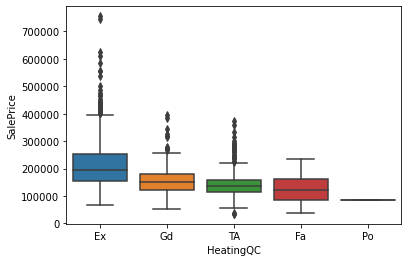

In [183]:
sns.boxplot(data=df_gptest,x='HeatingQC',y='SalePrice')

In [178]:
df_gptest['HeatingQC'].unique()

array(['Ex', 'Gd', 'TA', 'Fa', 'Po'], dtype=object)

In [187]:
df_gptest['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

We can see, that Po is only one example, so it would be better to drop this

In [179]:
f_val, p_val = stats.f_oneway(grouped_test1.get_group('Ex')['SalePrice'], grouped_test1.get_group('Gd')['SalePrice'],
                             grouped_test1.get_group('TA')['SalePrice'],grouped_test1.get_group('Fa')['SalePrice'],grouped_test1.get_group('Po')['SalePrice'])  

print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 88.39446198869796 , P = 2.667062092104357e-67


In [194]:
f_val, p_val = stats.f_oneway(grouped_test1.get_group('Ex')['SalePrice'],
                             grouped_test1.get_group('Po')['SalePrice'])

print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 2.135689232237604 , P = 0.14433025510817457


# preprocessing

## categorical

In [30]:
X_cat = X_full[low_categorical_col]
X_cat

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


In [31]:
cat_nans = X_cat.isna().sum()[X_cat.isna().sum() > 0]
cat_nans

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [32]:
X_cat.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [33]:
# do I need SaleCondition and SaleType?

In [34]:
#'CentralAir' probably should be boolean, maybe ohe works same

In [35]:
#probably, ordinalEncoder works better for this columns
cols_to_ordinal = ['ExterQual', 'ExterCond','HeatingQC', 'KitchenQual','FireplaceQu','GarageQual','GarageCond']
cols_to_ohe = [cols for cols in X_cat.columns 
               if cols not in cols_to_ordinal]
#BsmtQual BsmtCond BsmtExposure?

In [36]:
# Not sure why we need BSMtFinType2, it is strange, I will just drop the column
# Need drop\imputation: Electrical
# Should I drop where >1000 missed value?
# in most cases Nan means it is not exist, not missed value, so it is another categorical

### here should be experiments with preprocessing

In [37]:
cols_to_drop = ['BsmtFinType2', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [38]:
X_cat = X_cat.drop(cols_to_drop,axis=1)

In [39]:
cat_features = list(X_cat.columns)

## numeric

#### dropna
need to drop nan in case to use all numeric cols

In [40]:
print(numeric_col)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [41]:
X_numeric = X_full[numeric_col]
X_numeric

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,2003.0,2,548,0,61,0,0,0,0,0
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,1976.0,2,460,298,0,0,0,0,0,0
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,2001.0,2,608,0,42,0,0,0,0,0
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,1998.0,3,642,0,35,272,0,0,0,0
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,2000.0,3,836,192,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,1999.0,2,460,0,40,0,0,0,0,0
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,1978.0,2,500,349,0,0,0,0,0,0
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,1941.0,1,252,0,60,0,0,0,0,2500


In [42]:
X_numeric.isna().sum()[X_numeric.isna().sum() > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

#### find numeric columns that needs to bin

In [43]:
numeric_cols_better_to_bin = ['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea']
numeric_cols_should_be_categorical = [col for col in X_numeric.columns
                                      if X_numeric[col].nunique() <=20]
cols_to_bin = numeric_cols_better_to_bin + numeric_cols_should_be_categorical
print(cols_to_bin)

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea', 'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea']


In [44]:
print(cols_to_bin)

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea', 'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea']


In [45]:
X_numeric = X_numeric.drop(cols_to_bin, axis=1)
X_numeric

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal
Id,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706,0,150,856,856,854,0,1710,548,0,61,0,0,0
2,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0
3,68.0,11250,162.0,486,0,434,920,920,866,0,1786,608,0,42,0,0,0
4,60.0,9550,0.0,216,0,540,756,961,756,0,1717,642,0,35,272,0,0
5,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,62.0,7917,0.0,0,0,953,953,953,694,0,1647,460,0,40,0,0,0
1457,85.0,13175,119.0,790,163,589,1542,2073,0,0,2073,500,349,0,0,0,0
1458,66.0,9042,0.0,275,0,877,1152,1188,1152,0,2340,252,0,60,0,0,2500


In [46]:
X_full['TotRmsAbvGrd']

Id
1       8
2       6
3       6
4       7
5       9
       ..
1456    7
1457    7
1458    9
1459    5
1460    6
Name: TotRmsAbvGrd, Length: 1460, dtype: int64

In [47]:
#it is probably best to drop info about pool due to its fewness

In [48]:
X_boolean = pd.DataFrame()

In [49]:
X_boolean['Has_second_floor'] = X_numeric['2ndFlrSF'] > 0

In [50]:
X_boolean['Has_pool'] = X_full['PoolArea'] > 0
X_boolean['Has_garage'] = X_numeric['GarageArea'] > 0
X_boolean['Has_basement'] = X_numeric['BsmtFinSF1'] > 0

In [51]:
X_boolean

,Has_second_floor,Has_pool,Has_garage,Has_basement
Id,,,,
1,True,False,True,True
2,False,False,True,True
3,True,False,True,True
4,True,False,True,True
5,True,False,True,True
...,...,...,...,...
1456,True,False,True,False
1457,False,False,True,True
1458,True,False,True,True


# Pipelines

In [52]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid, model=None):
    
    if model is None:
        #model = RandomForestRegressor(random_state=42)
        model = LinearRegression()
        #model = Ridge(normalize=True)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

## only numerical transform

In [53]:
#xxx = X_full[numeric_col]

In [54]:
features = numeric_col

In [55]:
print(numeric_cols_should_be_categorical)

['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea']


In [56]:
print(cols_to_bin)

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea', 'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea']


In [57]:
numeric_cols_better_to_bin

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea']

In [58]:
years_to_bin = numeric_cols_better_to_bin[:3]
cols_to_bin_without_years = [col for col in cols_to_bin
                            if col not in years_to_bin]

In [59]:
#features = list(X_numeric.columns) + numeric_cols_should_be_categorical + years_to_bin + string_col

### All numeric data

In [60]:
cols = ['2ndFlrSF']

In [61]:
X = X_numeric.drop(cols, axis=1).join(X_boolean) # use all features is better

In [62]:
X

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,Has_second_floor,Has_pool,Has_garage,Has_basement
Id,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706,0,150,856,856,0,1710,548,0,61,0,0,0,True,False,True,True
2,80.0,9600,0.0,978,0,284,1262,1262,0,1262,460,298,0,0,0,0,False,False,True,True
3,68.0,11250,162.0,486,0,434,920,920,0,1786,608,0,42,0,0,0,True,False,True,True
4,60.0,9550,0.0,216,0,540,756,961,0,1717,642,0,35,272,0,0,True,False,True,True
5,84.0,14260,350.0,655,0,490,1145,1145,0,2198,836,192,84,0,0,0,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,62.0,7917,0.0,0,0,953,953,953,0,1647,460,0,40,0,0,0,True,False,True,False
1457,85.0,13175,119.0,790,163,589,1542,2073,0,2073,500,349,0,0,0,0,False,False,True,True
1458,66.0,9042,0.0,275,0,877,1152,1188,0,2340,252,0,60,0,0,2500,True,False,True,True


In [63]:
len(X_numeric.columns)

17

In [64]:
#X_train, X_valid, y_train, y_valid =  train_test_split(Full_train[features], y_full, random_state=42)
X_train, X_valid, y_train, y_valid =  train_test_split(X, y_full, random_state=42)

#### at first, let is see how dummy regressor works

In [65]:
dummy_regr = DummyRegressor(strategy='median', constant=0)
dummy_regr.fit(X_train, y_train)
pred = dummy_regr.predict(X_valid)
print('dummy_regr mae:')
print(mean_absolute_error(pred, y_valid))

dummy_regr mae:
57217.32054794521


Well, we will see, models work much better then dummy regressor

#### Approach 1: 
drop nan columns

In [66]:
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

print(cols_with_missing)

['LotFrontage', 'MasVnrArea']


In [67]:
from sklearn.linear_model import Lasso

In [68]:
# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1:")
base_model = Lasso(alpha=1000, max_iter=1000)
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid)) #22356.59375267366

MAE from Approach 1:
25996.749986846637


#### Approach 2:
Use SimpleImputer to impute missed values

In [69]:
# Imputation
my_imputer = SimpleImputer(strategy='median') # median works quite better
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2:")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 2:
25999.918470717723


#### Approach 3:
extention to imputation

In [70]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer(strategy='median') # almost nothing changes, but still quite better
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3:")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid,base_model ))

MAE from Approach 3:
26497.86735261704


### Summary:
It can be seen, that for numerical columns even simple imputation works better then dropping columns(at least for linear regression models), therefore
I will concetrate on checking other techniques, without double-checking how the same techinque will works for dropped columns

#### Approach 4:
Try to use some normalization\scaling techinques

##### Normalization

In [71]:
X_train_norm = X_train.copy()
X_valid_norm= X_valid.copy()

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('normalization', Normalizer()),
    #('model',RandomForestRegressor(random_state=42))
    ('model', Ridge())
    #('model', base_model)
])
print("MAE from Approach 4:")
print(score_dataset(X_train_norm, X_valid_norm, y_train, y_valid, pipe))

MAE from Approach 4:
57431.55949680938


##### scaling

In [72]:
X_train_scale = X_train.copy()
X_valid_scale = X_valid.copy()

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler()),
    ('model', LinearRegression())
    #('model', base_model)
])
print("MAE from Approach 4:")
print(score_dataset(X_train, X_valid, y_train, y_valid, pipe))
#22433.467501817053

MAE from Approach 4:
25999.918470717723


In [73]:
print(score_dataset(X_train_plus, X_valid_plus, y_train, y_valid, pipe))
#22203.291104332206

25986.544256863595


In [74]:
#cross_validation
cv_scores = cross_val_score(pipe, Full_train[features], y_full, 
                            cv=5,
                            scoring='neg_mean_absolute_error')

print("Cross-validation score: %f" % cv_scores.mean())

Cross-validation score: -21962.089313


## Summary:

## Try some data analysis
Next thing I want to try is creating categories(bins) from numeric data - like ranges from data that contains years, and so on.

In [75]:
numeric_cols_better_to_bin = ['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea']
numeric_cols_should_be_categorical = [col for col in X_numeric.columns
                                      if X_numeric[col].nunique() <=20]
cols_to_bin = numeric_cols_better_to_bin + numeric_cols_should_be_categorical
print(cols_to_bin)

['GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'PoolArea']


In [76]:
#X_numeric['BsmtHalfBath'].value_counts()

In [77]:
def numeric_transforms_comparation(numerical_transformer, features=numeric_col, n_bins=6):
    # Bundle preprocessing for numerical and categorical data
    cat_from_num_transform = Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value=0)),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
        #('ord', OrdinalEncoder())
    ])
    cols_to_bin_transform = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('bin', KBinsDiscretizer(n_bins=n_bins, encode='ordinal')),
    ])
    
    categorical_transformer = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, X_numeric.columns), # in this X i dropped columns that I will categorize
            #('num', numerical_transformer, numeric_col),
            ('cat_from_num', cat_from_num_transform, numeric_cols_should_be_categorical),#cols_to_bin
            ('years_to_bin', cols_to_bin_transform, years_to_bin),
            #('cat', categorical_transformer, string_col)
        ], remainder='drop')
    model = Pipeline([
        ('preprocess', preprocessor),
        ('model', LinearRegression()),
    ])
    #dumn = pd.get_dummies(Full_train[low_categorical_col].drop(['Alley'],axis=1))
    #X_train, X_valid, y_train, y_valid =  train_test_split(Full_train[features].join(dumn), y_full, random_state=42)
    X_train, X_valid, y_train, y_valid =  train_test_split(Full_train[features], y_full, random_state=42)
    model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    mse = mean_squared_error(prediction, y_valid)
    mae = mean_absolute_error(prediction, y_valid)
    print("mse:", mse)
    print("mae", mae)
    print(n_bins)
    return model

def find_opt_bin(numerical_transformer, max_bin=21):
    for n in range(2,max_bin):
        model=numeric_transforms_comparation(numerical_transformer, n_bins=n)
    return model
#761484416.334323

In [78]:
# numerical transformer - is transformer for columns in X_numeric
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='median') ),
])

In [79]:
model = numeric_transforms_comparation(numerical_transformer,features=features) # n_bins=12 for RandomForestRegressor

mse: 1498880494.6577973
mae 24189.35832751982
6


In [80]:
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('fe', SelectKBest(f_regression, k=7))
])

In [81]:
model = numeric_transforms_comparation(numerical_transformer,features=features) # n_bins=12 for RandomForestRegressor

mse: 1453733905.5681283
mae 24041.370744990905
6


In [82]:
model = numeric_transforms_comparation(numerical_transformer,features=features,n_bins=12) # n_bins=12 for RandomForestRegressor

mse: 1443147781.593864
mae 23846.83055271064
12


/home/leo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [83]:
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('gauss', PowerTransformer()),
   # ('fe', SelectKBest(f_regression, k=7))
])

In [84]:

model = numeric_transforms_comparation(numerical_transformer, features=features)
#model = find_opt_bin(numerical_transformer)

mse: 1785138473.0003352
mae 26025.932388353027
6


/home/leo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [85]:
# scaling
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

In [86]:
model = numeric_transforms_comparation(numerical_transformer, n_bins=10, features=features)

mse: 1462077918.9135277
mae 23750.403824155317
10


/home/leo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [87]:
# scaling min-max
numerical_transformer = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

In [88]:
model = numeric_transforms_comparation(numerical_transformer, n_bins=12, features=features)

mse: 1486467627.8442812
mae 23943.68179146949
12


/home/leo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:200: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [89]:
# best result
#mse: 761484416.334323
#mae 17537.177296803653

## only categorical transform

## combination of both methods

# Create sumbission on kaggle

In [90]:
#features = numeric_col #+ low_categorical_col

In [91]:
X_exam = Full_test[features].copy()

In [92]:
X_exam

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,1961.0,1.0,730.0,140,0,0,0,120,0,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,1958.0,1.0,312.0,393,36,0,0,0,0,12500
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,1997.0,2.0,482.0,212,34,0,0,0,0,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,1998.0,2.0,470.0,360,36,0,0,0,0,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,1992.0,2.0,506.0,0,82,0,0,144,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,NaN,0.0,0.0,0,0,0,0,0,0,0
1455,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,1970.0,1.0,286.0,0,24,0,0,0,0,0
1456,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,1960.0,2.0,576.0,474,0,0,0,0,0,0
1457,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,NaN,0.0,0.0,80,32,0,0,0,0,700


In [93]:
#sumbission on Kaggle
#predict_on_test = model.predict(X_exam)
#output = pd.DataFrame({'Id': Full_test.Id,
#                       'SalePrice': predict_on_test})
#output.to_csv('submission.csv', index=False)